# Initial Ideas for evaporator code

Here's some simple ideas for how best to code an evaporating body

#### Physical approach

Let's think about the real physics going on, and see if we can adapt known models to account for that.

The cause of the signal in evaporator transits is not the planet, but the dust cloud.

To me, this dust cloud has three possibilities:
 * Spherical cloud around planet which decreases density with distance
 * Smeared tail behind planet which decreases density with distance
 * Smeared tail in front of planet which decreases density with distance
 
In all three cases, we could iteractively fit a Mandel+Agol transit model to account for the change in size over time. e.g:
 
 <img src="MandelAgolIdeas.png">
 
 This is not quite what happens, because there's thinks like Roche lobe overflow at L1/L2, but maybe it's enough for a general model?

Alternatively, and possibly more realistically, these dust grains are pushed onto a new orbit, so potentially we should include a Keplerian signal for that which should include for curvature in the tail.

In any case, we would then have a couple of hyper parameters for each transit governing:
* the direction of motion of the dust cloud w.r.t. the planet (+ being leading, 0 being sphere, - being trailing)
* the rate of dispersion over time
* total dust production (which should governe depth)

In this sort of model, the dust would be conserved - i.e. the density of the dust between transit model iterations would be proportional to the change in area (i.e. dispersion)

##### Forward-scattering

 <img src="K222_model.jpg">

In the previous models (e.g. with Kepler), they have included a term to model the effect that this tail of dust is actually *scattering* (ie not just blocking) the light. That means less light in transit, but also extra light around transit due to the fact that the tail is directing light back to the observer.

Personally I think this is too much to include in the model because: 
* 3D reflection geometry is non-trivial
* It depends on both dust grain size & separation - two unknowns
* The amount of scattering will certainly be less with TESS because of the redder wavelength

But maybe we can include some sort of density-dependent boost effect around central transit with a couple of floating parameters:
* dust density : boost height ratio (for the height of the Gaussian)
* reflection angle (for the width of the Gaussian)

##### Pseudo code:

Parameters
* planet period = $P$
* planet transit time = $t_0$
* planet impact param = $b$
* either:
    * dust production mean = $D_\mu$
    * dust production std = $D_\sigma$
* or:
    * SHM kernel for dust production in celerite with parameters mean $D_\mu$ and lengthscale $l$.
* dust speed = $v$
* dust dispersion = $\delta$
* density to reflection boost = $b_D$
* reflection angle = $\Theta_b$

For each transit:
* draw dust production ($D_i$) from the $D_\mu$ and $D_\sigma$ distributions
* Create some number of steps to iterate over from -pi/2 to 0 in phase producing phantom planets at each

For each step:
* Using $v$ and the orbital velocity of the planet from ($P$) we generate an eccentric orbit for the M+A model. The new orbit is either at aphelion (for trailing tail) or perihelion (leading tail) at the 
* We then compute the new "phantom planet" orbit given $P$, $v$, $t_l$, $t_c$
* Depending on the $\delta$ and $t_l$ we calculate a new phantom planet radius, and a new "density" (e.g. alpha) for the transit.

Then, for each transit:
* Sum all the transit lightcurves for the phantom planets.
* Use $b_D$ and $\Theta_b$ to add a reflection boost

In [1]:
from astropy import units as u
from astropy import constants as c

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import exoplanet as xo
import theano.tensor as tt
import theano.tensor.extra_ops as ttx

import pandas as pd
dat=np.genfromtxt("k1255_lc.dat")

import pymc3 as pm
%load_ext autoreload
%autoreload 2

In [2]:
c.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

Let's use the Hill sphere for a Mars-mass body as our initial Radius:

$r_{\mathrm {H} }\approx a(1-e){\sqrt[{3}]{\frac {m}{3M}}}$

In [ ]:
#Taking a snippet of KIC1255 data for the model:
t=dat[22000:31500,0]
flux= dat[22000:31500,1]-np.nanmedian(dat[22000:31500,1])
flux_err= dat[22000:31500,2]
cadence=np.nanmedian(np.diff(t))

In [227]:
#Orbital params from BLS/candidate - we can fix these here as they should be good enough
t_0=566.824+0.5
P=0.6535538

Checking the data works ok:

(-0.02, 0.01)

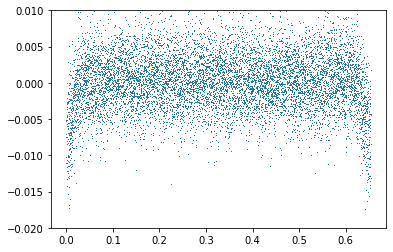

In [253]:
plt.plot((t-t_0)%P,flux,',')
plt.ylim(-0.02,0.01)

We're actually 0.5P out, so I adjusted this above and now it works great!

In [267]:
# initial parameters
use_gp=True
init_planet_mass=0.1 #Roughly Mars mass - should be undetectably small yet big enough to have a big hill sphere.
n_steps=50
phase_coverage=0.1

#Counting number of transits to model, and assigning time to each nearby transit:
phase        = (t-t_0)/P
rounded_phase= np.round(phase)
trns_numbers = np.unique(rounded_phase)
phase_index  = np.vstack([[rounded_phase==n_tr] for n_tr in trns_numbers])

#Stellar params from e.g. TIC:
Rs=1.0#Rs=pm.Normal('Rs',mu=1.0,sd=0.1)
Ms=1.0#Ms=pm.Normal('Ms',mu=1.0,sd=0.15)

with pm.Model() as model:
    #b can just be unit uniform:
    b=pm.Uniform('b',lower=0.0,upper=1.00)
    t_offset=pm.Uniform('t_offset',lower=0.0,upper=P)
    
    #For now, let's just model lightcurve depth for every transit:
    log_depths=pm.Bound(pm.Normal, upper=-1,lower=-10)("log_depths", mu=-5, sigma=6.0,shape=len(trns_numbers))
    
    '''
    #This is where we could put a GP:
    
    from exoplanet import estimate_inverse_gamma_parameters
    from exoplanet.gp import terms, GP

    #Getting depths with GP
    if use_gp:
        #Getting dust production from a GP
        #dust_mean=pm.Uniform('dust_mean',lower=0,upper=0.5)
        log_mean_depths = pm.Normal("log_mean_depths", mu=-3, sigma=6.0)
        S1 = pm.InverseGamma(
            "S1", **estimate_inverse_gamma_parameters(0.5 ** 2, 10.0 ** 2)
        )
        w1 = pm.InverseGamma(
            "w1", **estimate_inverse_gamma_parameters(2 * np.pi / 20.0, 0.125*np.pi)
        )
        # Set up the kernel an GP
        kernel = terms.SHOTerm(S_tot=S1, w0=w1, Q=1.0 / np.sqrt(2))
        sigma = pm.Lognormal("sigma", mu=np.log(0.0), sigma=10)
        log_depth_gp = GP(kernel, trns_numbers, sigma ** 2 + tt.zeros(len(trns_numbers)), mean=log_mean_dust)
        
        #Using our GP to predict log depth and applying this:
        log_depth_gp.compute(trns_numbers,sigma)
        dust_prod_pred = tt.exp(log_depth_gp.predict(trns_numbers,return_var=False))
    '''
    
    #This is the relative speed of the dust with respect to the planet. i.e. <0 = in-falling. >0 = propelled outward.
    #NB - dust_vel<<1.41 (as sqrt(2)*v_circ = unbound from th solar system!).
    dust_vel=pm.Bound(pm.Normal, upper=1.25,lower=0.5)('dust_vel',mu=1.0,sd=0.033)
    
    #We want to define our dusty "phantom planets" as kicked off their planet and moving along eccentric orbits
    #As velocity should be the same, we should always have the same eccentricity, and the same "period", so initialising here:
    sma_circ    = (((6.67e-11*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
    ecc_phantom = abs(dust_vel**2-1)
    per_phantom = (np.sqrt((4*np.pi**2*((sma_circ*u.AU.to(u.m))/(1+ecc_phantom))**3)/(6.67e-11*(u.Msun.to(u.kg))*Ms)))/86400
    # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)

    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = pm.Uniform("log_rad_growth",lower=-6,upper=1)
    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios     = init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
    planet_ratios     = (planet_ratios-planet_ratios[0])/(2*planet_ratios[-1])+init_planet_ratio #Limiting it at 0.5
    
    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=pm.Uniform("log_dust_dispersion",lower=2,upper=10)
    dispersion        = pm.Deterministic("dispersion", 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps)))
    
    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 
    if tt.lt(dust_vel,0):
        phantom_t_peris = -0.5*per_phantom - np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(0.5*np.pi-1*phase_coverage*2*np.pi, 0.5*np.pi, n_steps)%(np.pi*2)
    else:
        phantom_t_peris = -1*np.linspace(-1*phase_coverage*P, 0.0, n_steps)
        phantom_omega = np.linspace(1.5*np.pi-1*phase_coverage*2*np.pi, 0.5*np.pi, n_steps)%(np.pi*2)
    
    #Defining limb darkening
    u_star_tess = xo.distributions.QuadLimbDark("u_star_tess", testval=np.array([0.3, 0.2]))
    
    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=tt.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=tt.tile(ecc_phantom,n_steps),
                                     b=tt.tile(b,n_steps))
    
    #To track parameters for debugging I intialise some lists here:
    models=[]
    disp_lcs=[]
    all_lcs=[]
    mins=[]
    
    #looping over each transit:
    for n_tr in range(len(trns_numbers)):
        #For each of the phantom planet orbits, we generate a transit lightcurve with radius ratio determined by log_rad_growth
        #Here, t is transformed to phase between -0.5 and 0.5 so that the above eccentric/non-similar-period phantom planets are always correctly phased
        lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                                t=t[rounded_phase==trns_numbers[n_tr]]-t_0-trns_numbers[n_tr]*P+t_offset,
                                                                use_in_transit=True)
        
        all_lcs+=[pm.Deterministic("all_lcs_"+str(n_tr),lc)]
        #Multiplying the lightcurve by the dispersion as a function of time/dust-planet-size, and summing on 1D axis
        disp_lcs+=[pm.Deterministic("disp_lc_"+str(n_tr),tt.sum(lc*dispersion.dimshuffle('x',0),axis=1))]
        #Getting the minimum transit depth from the model. Clipping this so minimum is never 0 (which -> NaNs)
        mins+=[pm.Deterministic("mins_"+str(n_tr),tt.clip(tt.min(disp_lcs[n_tr]),-1e5,-1e-20))]
        #Reparameterising the transit depth using the minimum and the log_depths param
        models+=[np.exp(log_depths[n_tr])*-1*(disp_lcs[n_tr]/mins[n_tr])]
        
    #Stacking individual transits:
    stacked_lc = pm.Deterministic("stacked_lc",tt.concatenate(models))
    
    #Likelihood of the model:
    pm.Normal("likelihood",mu=stacked_lc, sigma=flux_err, observed=flux)
    
    #return final_model

/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [268]:
with model:
    map_estimate = pm.find_MAP(model=model, method="powell")

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/hosborn/transits/lib/python3.7/site-packages/scipy/optimize/_minimize.py:500: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = 34,521, ||grad|| = 134.12: 100%|██████████| 511/511 [00:45<00:00, 11.21it/s]  


In [286]:
import seaborn as sns
sns.set_palette('viridis')

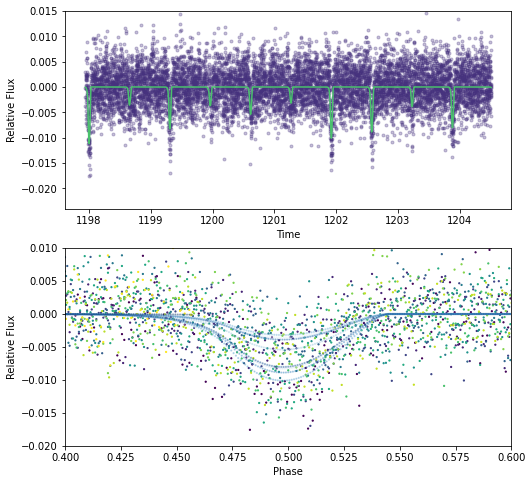

In [292]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(t,flux,'.',alpha=0.3)
plt.plot(t,map_estimate['stacked_lc'],'-',color='C4')

plt.ylim(-0.024,0.015)
plt.xlabel("Time")
plt.ylabel("Relative Flux")

plt.subplot(212)
plt.scatter((phase-0.5)%1,flux,c=phase-phase[0],cmap='viridis',s=1.5)
plt.scatter((phase-0.5)%1,map_estimate['stacked_lc'],c=phase-phase[0],cmap='Blues',s=1.5,alpha=0.3)
plt.xlim(0.4,0.6)

plt.ylim(-0.02,0.01)
plt.xlabel("Phase")
plt.ylabel("Relative Flux")
plt.savefig("WorkingStackedTransitModel.png",dpi=300)


In [271]:
phase

array([964.90465204, 964.90569437, 964.90673654, ..., 974.95463509,
       974.95567726, 974.95671944])

## Offset

So we have a little offset here and I'm not sure what could be causing it.
The t_0 definitely matches the data.

But we're using t_0 to reparameterise t_periasteron (in order to allow multiple t_transits and a blurred-out transit).

So the bug must be there...

In [234]:
map_estimate['stacked_lc'][200:400]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [235]:
map_estimate

{'b_interval__': array(47.59527119),
 'log_depths_interval__': array([-70.23548102, -70.23548102, -70.23548102, -70.23548102,
        -70.23548102, -70.23548102, -70.23548102, -70.23548102,
        -70.23548102, -70.23548102, -41.40483592]),
 'dust_vel_interval__': array(0.69314718),
 'log_rad_growth_interval__': array(-70.23548102),
 'log_dust_dispersion_interval__': array(45.00734223),
 'u_star_tess_quadlimbdark__': array([-56.91288648,  -0.85811215]),
 'b': array(1.),
 'log_depths': array([-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.]),
 'dust_vel': array(1.),
 'log_rad_growth': array(-6.),
 'log_dust_dispersion': array(10.),
 'dispersion': array([2.50000000e-01, 2.03848763e-01, 1.66217272e-01, 1.35532741e-01,
        1.10512726e-01, 9.01115297e-02, 7.34764953e-02, 5.99123705e-02,
        4.88522504e-02, 3.98338831e-02, 3.24803511e-02, 2.64843175e-02,
        2.15951814e-02, 1.76086040e-02, 1.43579686e-02, 1.17074165e-02,
        9.54616947e-03, 7.78389933e-03, 6.34695299e-

In [236]:
np.exp(-3)

0.049787068367863944

In [202]:
map_estimate['mins_0']

array(0.)

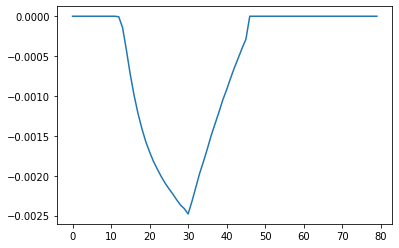

In [168]:
plt.plot(np.sum(map_estimate['all_lcs_0'][100:180,:],axis=1))

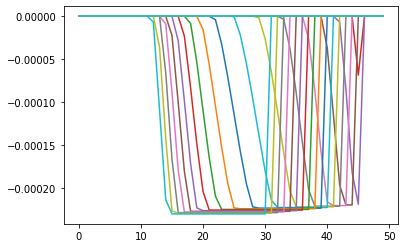

In [169]:
for n in range(n_steps):
    plt.plot(map_estimate['all_lcs_0'][100:150,n])
    

In [171]:
map_estimate

{'b_interval__': array(52.92713253),
 'log_depths_interval__': array([463.41370744, 463.41370744, 463.41370744, 463.41370744,
        463.41370744, 463.41370744, 463.41370744, 463.41370744,
        463.41370744, 463.41370744, 463.41370744]),
 'dust_vel_interval__': array(9.75948903),
 'log_rad_growth_interval__': array(-743.0438487),
 'log_dust_dispersion_interval__': array(463.41370744),
 'u_star_tess_quadlimbdark__': array([-672.4653046,    1.7406311]),
 'b': array(1.333),
 'log_depths': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 'dust_vel': array(1.24995669),
 'log_rad_growth': array(-6.),
 'log_dust_dispersion': array(10.),
 'u_star_tess': array([ 1.61010874e-146, -6.63840054e-147]),
 'all_lcs_0': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'disp_lc_0': array

In [170]:
for n in range(n_steps):
    plt.plot(map_estimate['all_lcs_0'][100:150,n]*map_estimate['dispersion'][n])
    

KeyError: 'dispersion'

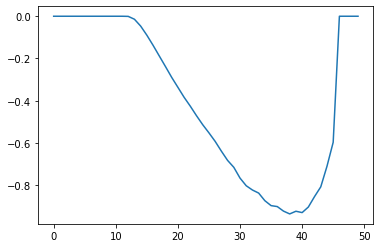

In [157]:
plt.plot(map_estimate['stacked_lc'][100:150])

In [46]:
phase

array([965.6697    , 965.67074232, 965.6717845 , ..., 975.71968305,
       975.72072522, 975.7217674 ])

In [48]:
t[rounded_phase==trns_numbers[0]]

array([1197.94110198, 1197.94178319, 1197.94246431, 1197.94314533,
       1197.94382644, 1197.94450766, 1197.94518878, 1197.94586999,
       1197.94655111, 1197.94723222, 1197.94791344, 1197.94859456,
       1197.94927557, 1197.94995679, 1197.9506379 , 1197.95131902,
       1197.95200014, 1197.95268135, 1197.95336247, 1197.95404359,
       1197.9547247 , 1197.95540582, 1197.95608693, 1197.95676815,
       1197.95744927, 1197.95813038, 1197.9588116 , 1197.95949271,
       1197.96017373, 1197.96085485, 1197.96153606, 1197.96221718,
       1197.9628983 , 1197.96357951, 1197.96426063, 1197.96494184,
       1197.96562286, 1197.96630398, 1197.96698509, 1197.96766631,
       1197.96834743, 1197.96902854, 1197.96970976, 1197.97039087,
       1197.97107209, 1197.97175311, 1197.97243422, 1197.97311534,
       1197.97379655, 1197.97447767, 1197.97515889, 1197.97584   ,
       1197.97652112, 1197.97720214, 1197.97788335, 1197.97856447,
       1197.97924558, 1197.9799268 , 1197.98060792, 1197.98128

In [33]:
xo.LimbDarkLightCurve?
#(u_star_tess).get_light_curve?

In [ ]:
xo.LimbDarkLightCurve().get_light_curve

In [ ]:
xo.LimbDarkLightCurve(u_star_tess).get_light_curve

In [25]:
ttx.Unique?

In [5]:
tt.lt?

In [148]:
tt.linspace?

Object `tt.linspace` not found.


149597870700.0

In [103]:
paramdic['Ms']=1.0*u.Msun
paramdic['Rs']=1.0*u.Rsun
paramdic['P']=1.0*u.day
paramdic['t_0']=0.25
paramdic['b']=0.2
paramdic['dust_dispersion']=1.04
paramdic['dust_vel']=1.01

EvapModel(t, paramdic)

0.0


TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [97]:
trns_numbers*paramdic['P'].value

array([0., 1., 2., 3., 4.])

In [75]:
xo.orbits.KeplerianOrbit?

In [ ]:
Ms=1.0*u.Msun
P=365.25*u.day
paramdic={'dust_vel':

In [ ]:
    sma_circ    = (c.G*Ms*P**2/(4*np.pi**2))**(1/3)
    if paramdic['dust_vel']>=0:
        ecc_phantom = 1-(sma_circ/(c.G*Ms))*(np.sqrt(c.G*Ms)/sma_circ+paramdic['dust_vel'])**2
    elif paramdic['dust_vel']<0:
        ecc_phantom = 1-(sma_circ/(c.G*Ms))*(np.sqrt(c.G*Ms)/sma_circ+paramdic['dust_vel'])**2
        #(np.sqrt((c.G*Ms)/sma_circ)+paramdic['dust_vel'])**2/(c.G*Ms)-1/sma_circ
    per_phantom = np.sqrt((4*np.pi**2*sma_circ/(1+ecc_phantom)**3)/(c.G*Ms))


In [18]:
1.41**2-1

0.9880999999999998